# **Project Idea**

- The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they want to get provide data-driven suggestions based on the collected data. The company wants to know what’s likely to make the employee leave the company. 

- This project is to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company. The model is also to identify possible factors that contribute to the employee's leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### The HR Dataset 

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables are shown as below: 

Feature  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## Step 1. Import Packages and Load Data

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

In [2]:
# Load dataset into a dataframe
df = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

## Step 2. Data Exploration (EDA)

In [3]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Gather descriptive statistics about the data
df.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [5]:
# Rename columns as needed
df = df.rename(columns={'Work_accident': 'work_accident',
                        'average_montly_hours': 'average_monthly_hours',
                        'time_spend_company': 'tenure',
                        'Department': 'department'
                        }
              )

# Display all column names after the update
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [6]:
# Check for missing values
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [7]:
# Check for duplicates
df.duplicated().sum()

3008

**Insight** 
- 3,008 rows contain duplicates. That is 20% of the data.

In [9]:
# Inspect some rows containing duplicates as needed
df[df.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

**Insight** 
- The above output shows the first five occurences of rows that are duplicated farther down in the dataframe. We could perform a likelihood analysis by essentially applying Bayes' theorem and multiplying the probabilities of finding each value in each column, but this does not seem necessary. With several continuous variables across 10 columns, it seems very unlikely that these observations are legitimate. WE can proceed by dropping them.

In [8]:
# Drop duplicates and save resulting dataframe in a new variable as needed
data = df.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
data.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

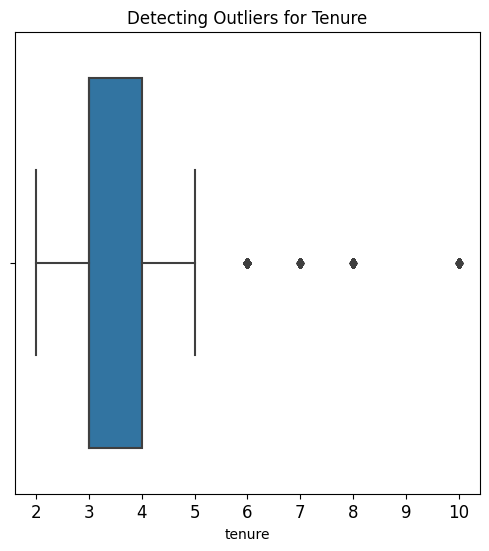

In [9]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
sns.boxplot(x=data['tenure'])
plt.title('Detecting Outliers for Tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
# It would be helpful to investigate how many rows in the data contain outliers in the `tenure` column


# Compute the 25th percentile value in `tenure`
percentile25 = data['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75 = data['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = data[(data['tenure'] > upper_limit) | (data['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


**Rule** 
- Certain types of models are more sensitive to outliers than others. When we get to the stage of building our model, we should consider whether to remove these outliers based on the type of model we decide to use or not.

## Step 2. Data Exploration (Continue EDA)
In this stage, it would be helpful to create plots to visualize relationships between variables in the data. 

Creating a stacked boxplot showing `average_monthly_hours` distributions for `number_project`, comparing the distributions of employees who stayed versus those who left.

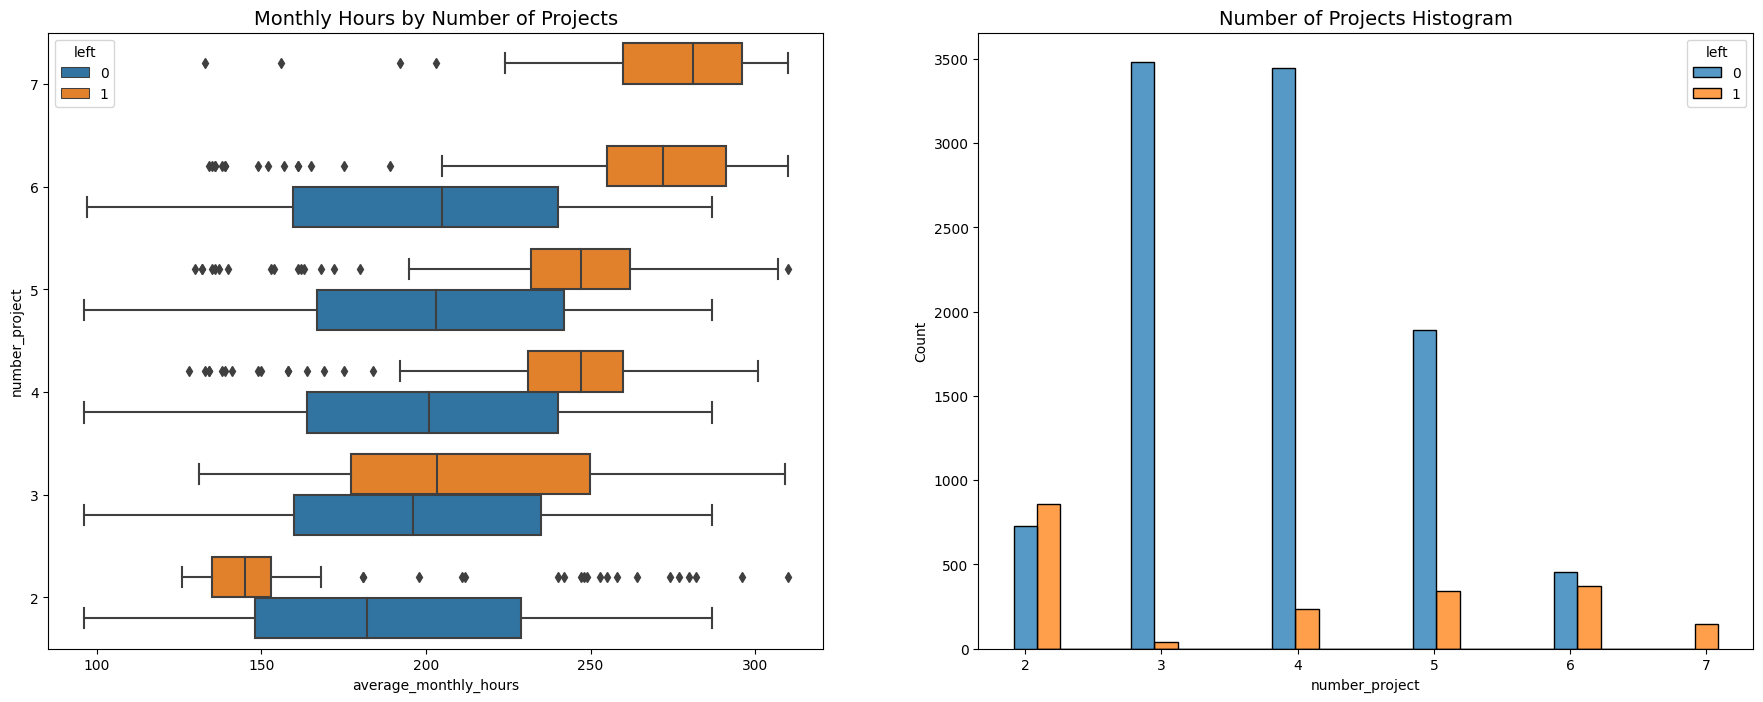

In [21]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=data, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly Hours by Number of Projects', fontsize='14')

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
sns.histplot(data=data, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of Projects Histogram', fontsize='14')

# Display the plots
plt.show()

**Insight** 
- It might be natural that people who work on more projects would also work longer hours. This appears to be the case here, with the mean hours of each group (stayed and left) increasing with number of projects worked. However, a few things stand out from this plot.

1. There are two groups of employees who left the company: 
    **(A)** Those who worked considerably less than their peers with the same number of projects.
    **(B)** Those who worked much more. 

    **For those in group A**, it's possible that they were fired. It's also possible that this group includes employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. 

    **For those in group B**, it's reasonable to infer that they probably quit. The folks in group B likely contributed a lot to the projects they worked in; they might have been the largest contributors to their projects. 

2. Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255&ndash;295 hours/week&mdash;much more than any other group. 

3. The optimal number of projects for employees to work on seems to be 3&ndash;4. The ratio of left/stayed is very small for these cohorts.

4. If we assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday&ndash;Friday `= 50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that, aside from the employees who worked on two projects, every group&mdash;even those who didn't leave the company&mdash;worked considerably more hours than this. It seems that employees here are overworked.

In [12]:
# Get value counts of stayed/left for employees with 7 projects
data[data['number_project'] == 7]['left'].value_counts()

1    145
Name: left, dtype: int64

Now, we could examine the average monthly hours versus the satisfaction levels as shown below: 

Text(0.5, 1.0, 'Monthly Hours by Last Evaluation Score')

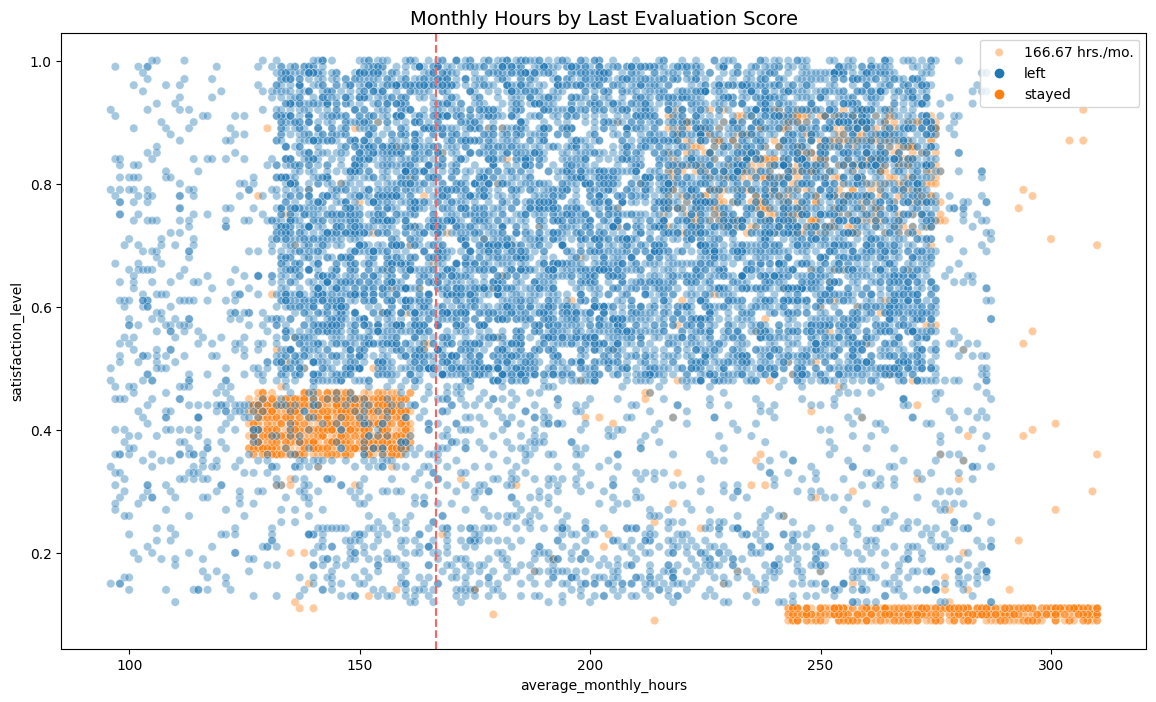

In [17]:
# Create scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(14, 8))
sns.scatterplot(data=data, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')        # 166.67 comes from the previous insight, point 4
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly Hours by Last Evaluation Score', fontsize='14')

**Insight** 
- The scatterplot above shows that there was a sizeable group of employees who worked ~240&ndash;315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero. 

- The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels. 

- Finally, there is a group who worked ~210&ndash;280 hours per month, and they had satisfaction levels ranging ~0.7&ndash;0.9. 

Now, it might be interesting to visualize satisfaction levels by tenure.

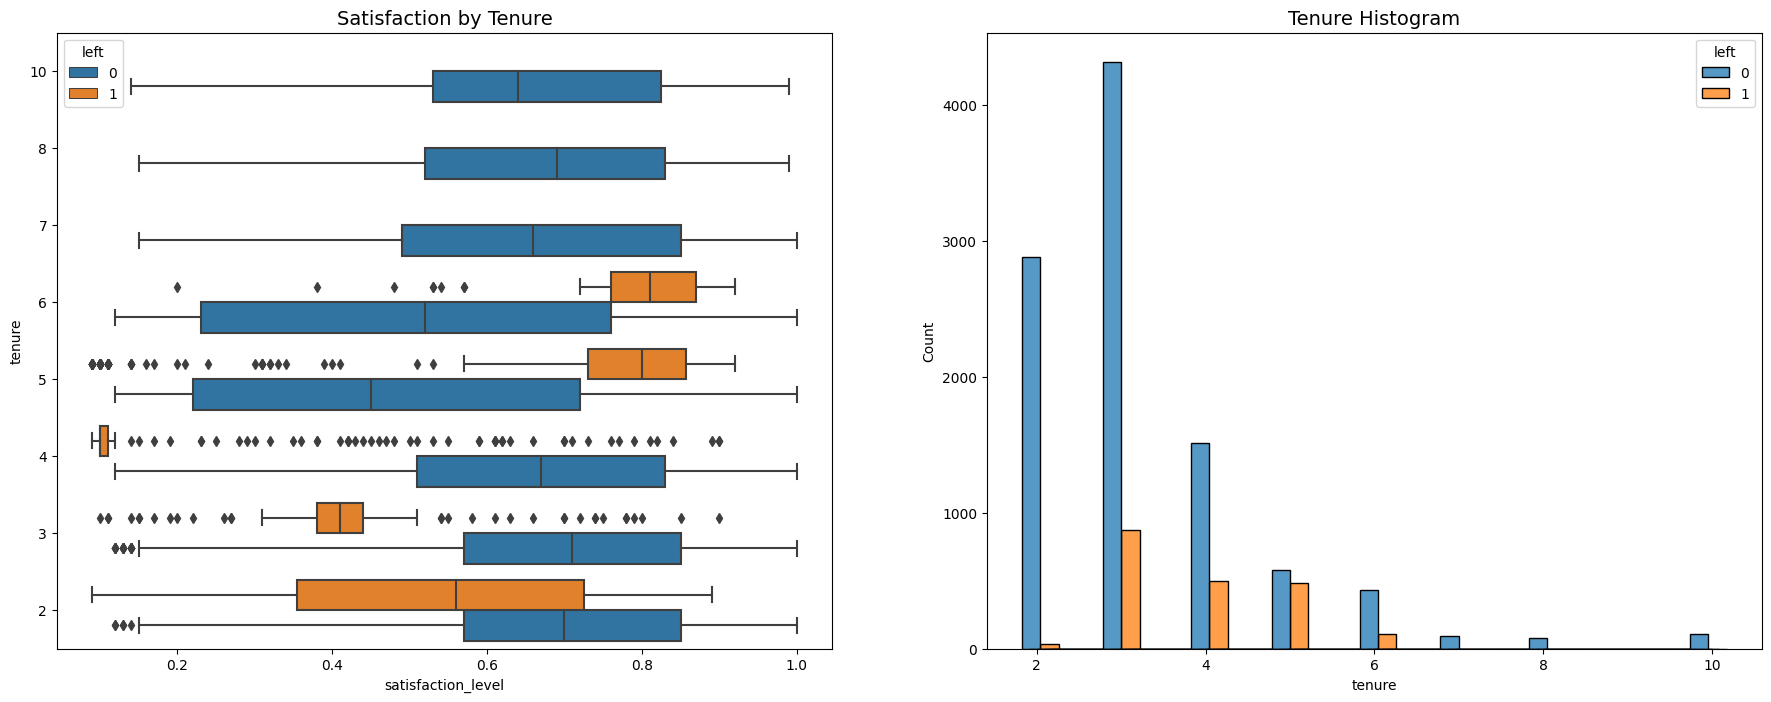

In [23]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=data, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by Tenure', fontsize='14')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
sns.histplot(data=data, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure Histogram', fontsize='14')

plt.show()

**Insight**
- Employees who left fall into two general categories: **dissatisfied** employees with shorter tenures and **very satisfied** employees with medium-length tenures.
- Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible. 
- The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed. 
- The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.

In [17]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
data.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

**Insight** 
- As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed. Interestingly, among employees who stayed, the mean satisfaction score appears to be slightly below the median score. **This indicates that satisfaction levels among those who stayed might be skewed to the left**. 

Now, we could examine salary levels for different tenures.

Text(0.5, 1.0, 'Salary histogram by tenure: long-tenured people')

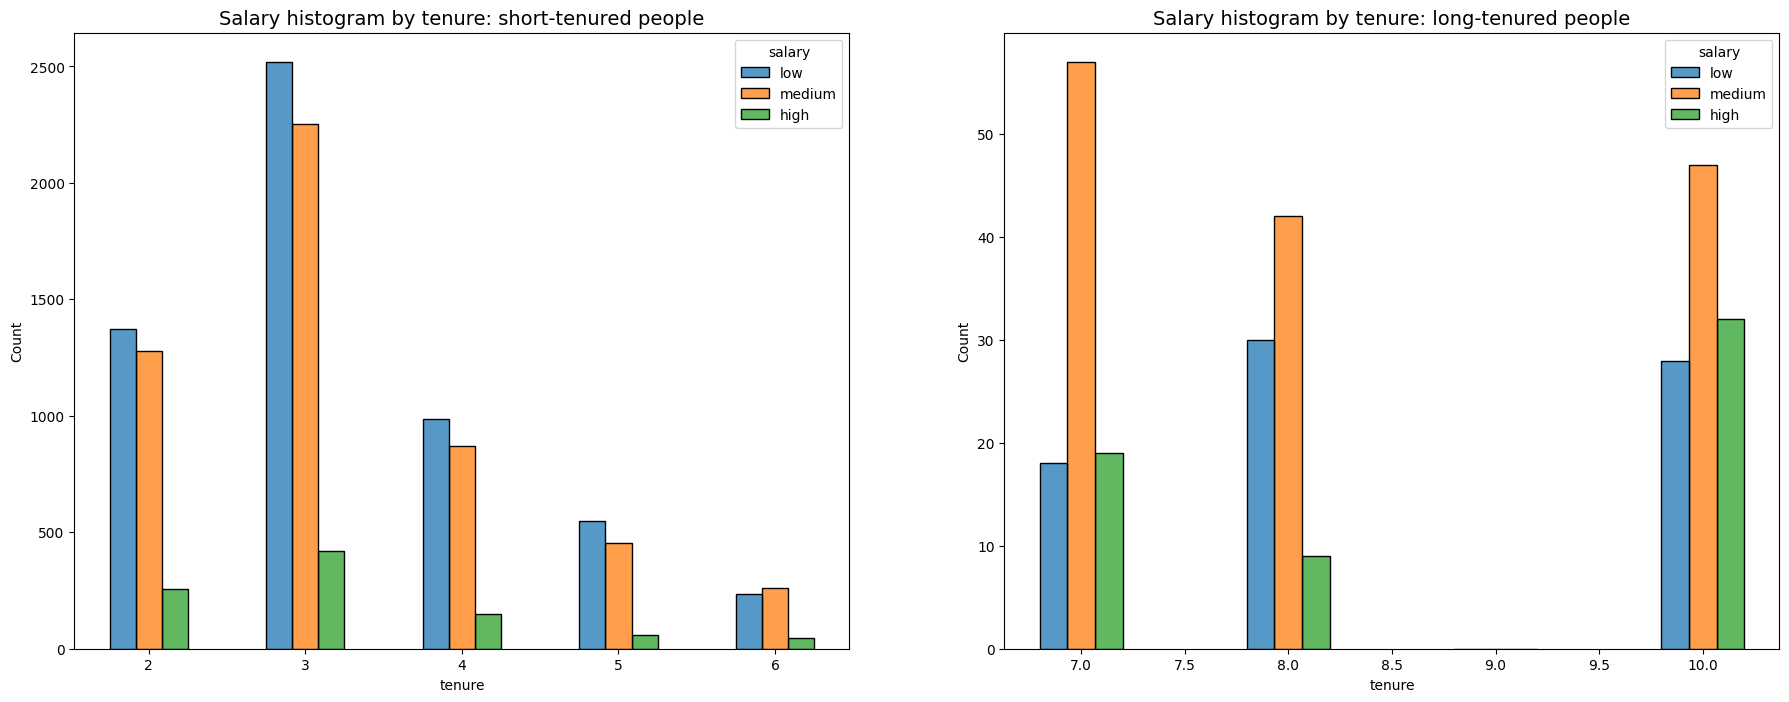

In [24]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees < 7 years
tenure_short = data[data['tenure'] < 7]

# Define long-tenured employees > 6 years
tenure_long = data[data['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by Tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary Histogram by Tenure: long-tenured people', fontsize='14')

**Insight** 
- The plots above show that long-tenured employees were not disproportionately comprised of higher-paid employees. So, it is worth to explore whether there's a correlation between working long hours and receiving high evaluation scores. We could create a scatterplot of `average_monthly_hours` versus `last_evaluation`.

Text(0.5, 1.0, 'Monthly Hours by Last Evaluation Score')

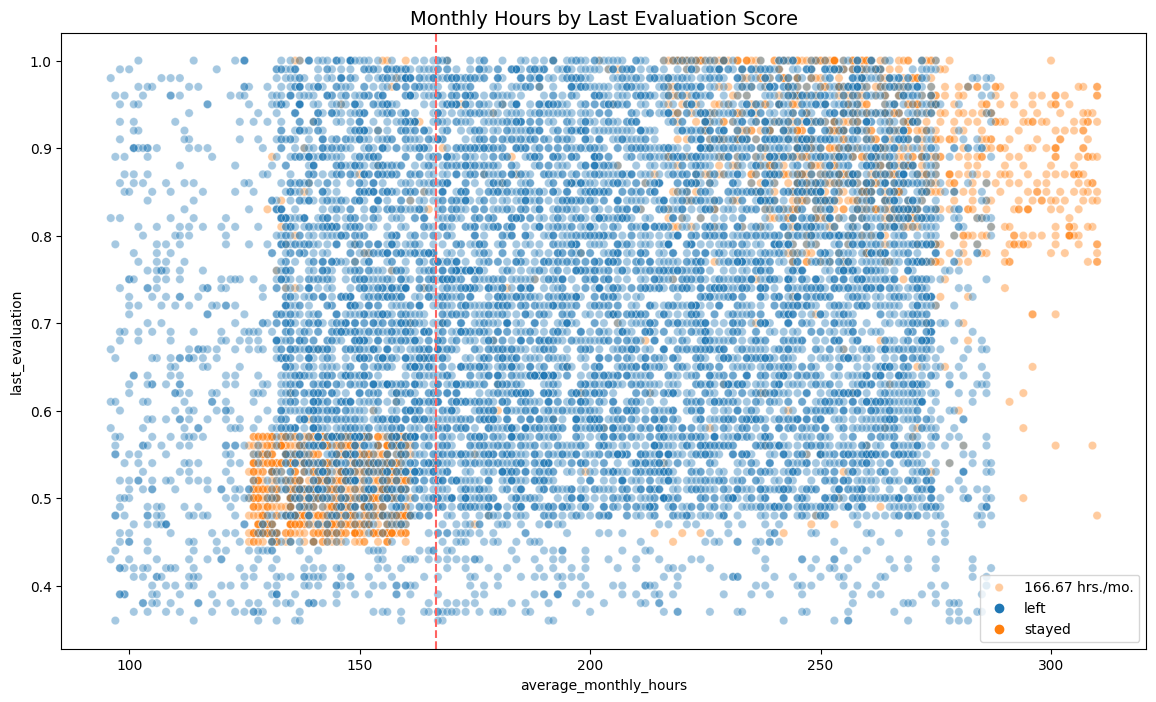

In [26]:
# Create scatterplot of `average_monthly_hours` versus `last_evaluation`
plt.figure(figsize=(14, 8))
sns.scatterplot(data=data, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly Hours by Last Evaluation Score', fontsize='14')

**Insight**
- The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores. 
- There seems to be a correlation between hours worked and evaluation score. 
- There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
- Most of the employees in this company work well over 167 hours per month.

Next, it is worth to examine whether employees who worked very long hours were promoted in the last five years.

Text(0.5, 1.0, 'Monthly hours by promotion last 5 years')

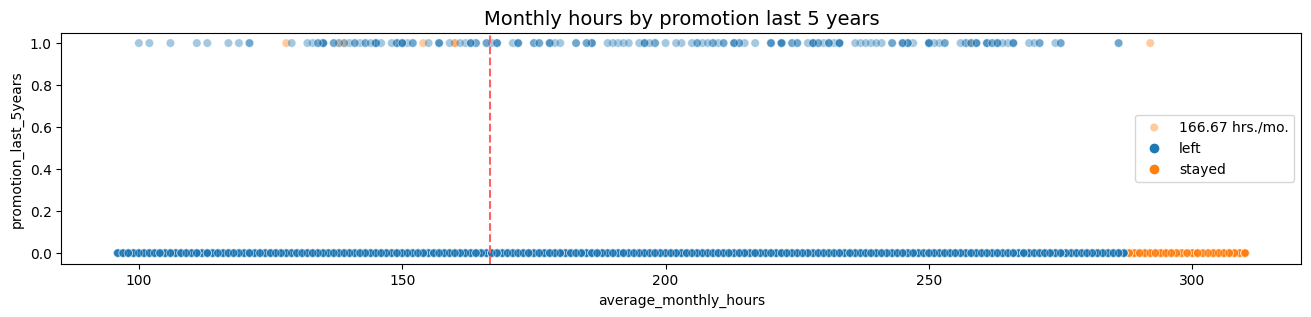

In [27]:
# Create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16, 3))
sns.scatterplot(data=data, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly Hours by Promotion Last 5 Years', fontsize='14')

**Insight**
- very few employees who were promoted in the last five years left
- very few employees who worked the most hours were promoted
- all of the employees who left were working the longest hours  

Now, we could inspect how the employees who left are distributed across the different departments.

In [28]:
# Display counts for each department
data["department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

Text(0.5, 1.0, 'Counts of stayed/left by Department')

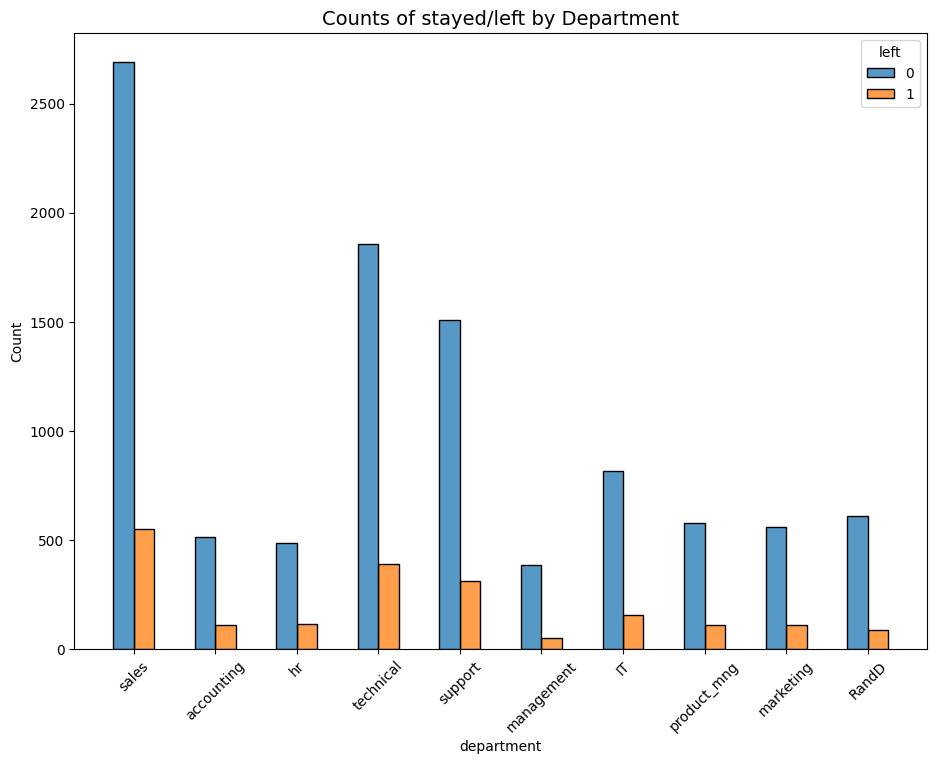

In [30]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=data, x='department', hue='left', discrete=1, hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by Department', fontsize=14)

**Insight** 
- There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed. 

Now, we could check for strong correlations between variables in the data.

C:\Users\Asaad\AppData\Local\Temp\ipykernel_8560\4165687298.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))


Text(0.5, 1.0, 'Correlation Heatmap')

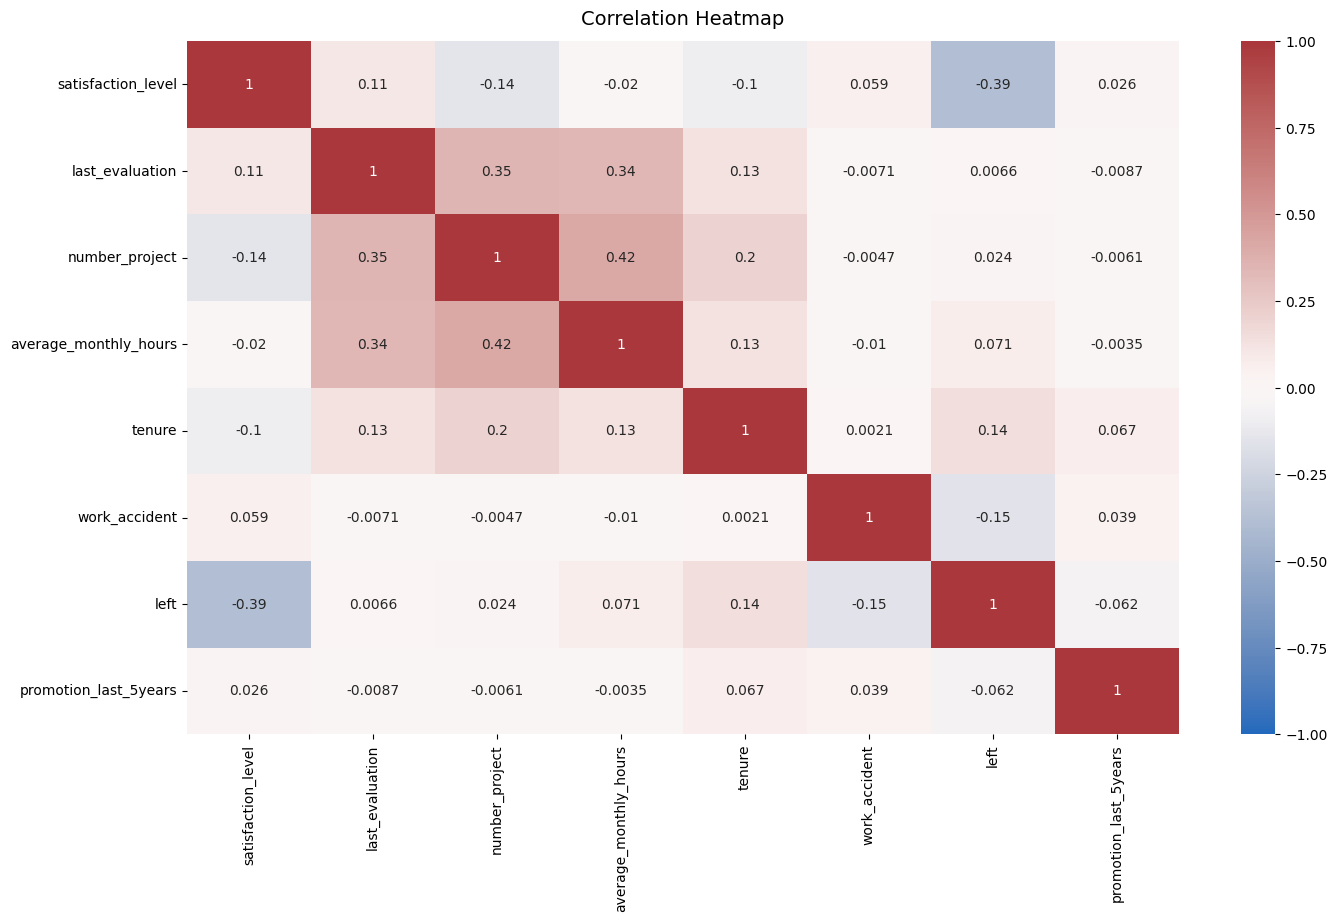

In [36]:
# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

**Insight** 
- The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

## Step 3. Model Building and Results Evaluation

- Since the feature we want to predict (whether an employee leaves the company) is categorical, so this task involves classification. More specifically, this involves binary classification, since the outcome feature `left` can be either 1 (indicating employee left) or 0 (indicating employee didn't leave). 

- We could build either a Logistic Regression or a Tree-based model.

### Modeling Approach A: Logistic Regression Model

In [38]:
# One-hot encode the categorical variables as needed and save resulting dataframe in a new variable
df_enc = pd.get_dummies(data, prefix=['salary', 'dept'], columns = ['salary', 'department'], drop_first=False)

# Display the new dataframe
df_enc.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary_high  \
0       3              0     1                      0            0   
1       6              0     1                      0            0   
2       4              0     1                      0            0   
3       5              0     1                      0            0   
4       3              0     1                      0            0   

   salary_low  salary_medium  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0           1              0        0           0                0        0   
1           0              1        0           0                0        0   
2           0              1        0           0                0        0   
3           1              0        0           0                0        0   
4           1              0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
1                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   

   dept_support  dept_technical  
0             0               0  
1             0               0  
2             0               0  
3             0               0  
4             0               0

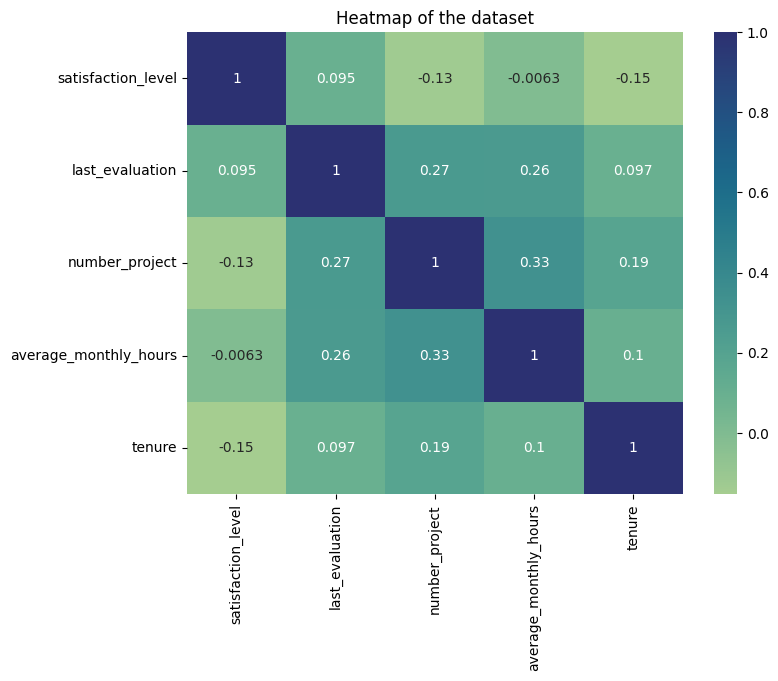

In [39]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

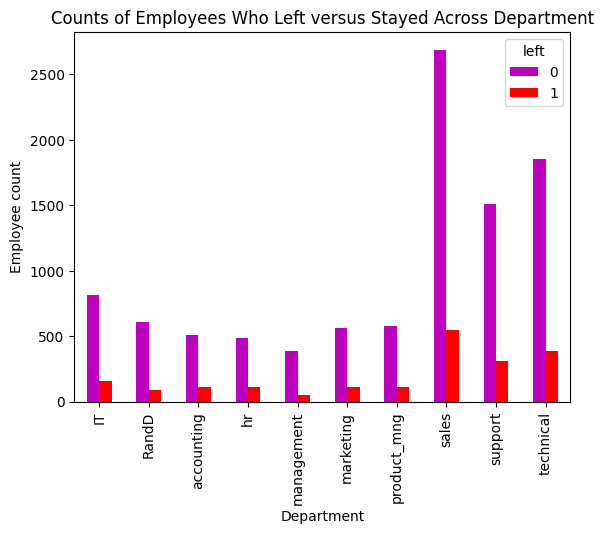

In [40]:
# Create a stacked bar plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(data["department"], data["left"]).plot(kind ='bar', color='mr')
plt.title('Counts of Employees Who Left versus Stayed Across Department')
plt.ylabel('Employee Count')
plt.xlabel('Department')
plt.show()

In [41]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary_high  \
0       3              0     1                      0            0   
2       4              0     1                      0            0   
3       5              0     1                      0            0   
4       3              0     1                      0            0   
5       3              0     1                      0            0   

   salary_low  salary_medium  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0           1              0        0           0                0        0   
2           0              1        0           0                0        0   
3           1              0        0           0                0        0   
4           1              0        0           0                0        0   
5           1              0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  
0             0               0  
2             0               0  
3             0               0  
4             0               0  
5             0               0

In [42]:
# Select the predictor features to use in the model
X = df_logreg[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'work_accident', 'promotion_last_5years', 'salary_high', 'salary_low', 'salary_medium' , 'dept_IT', 'dept_RandD', 'dept_accounting', 'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng', 'dept_sales', 'dept_support', 'dept_technical']]

# Isolate the outcome feature
y = df_logreg['left']

In [43]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [45]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

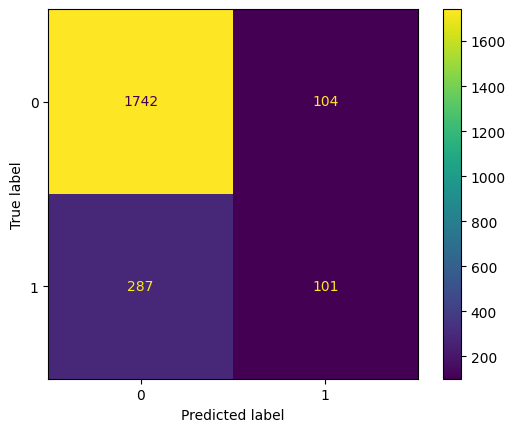

In [46]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [47]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.94      0.90      1846
    Predicted would leave       0.49      0.26      0.34       388

                 accuracy                           0.82      2234
                macro avg       0.68      0.60      0.62      2234
             weighted avg       0.80      0.82      0.80      2234



**Insight** 
- The classification report above shows that the logistic regression model achieved a `precision` of 80%, `recall` of 83%, `f1-score` of 80% (all weighted averages), and `accuracy` of 83%.

### Modeling Approach B: Tree-based Model

In [48]:
# Encode categorical variables
df_tree = pd.get_dummies(data)

In [49]:
# Select the predictor features
X = df_tree.drop('left', axis=1)

# Isolate the outcome feature
y = df_tree['left']

In [50]:
# Split the data to train and test, a ratio of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Split the data to train, validate and test, a final ratio of 80/20/20
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

#### Decision Tree - Round 1

In [56]:
# Instantiate `DecisionTreeClassifier` model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
dtree1_cv = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [57]:
# Fit the decision tree model to the training data.
%time
dtree1_cv.fit(X_tr, y_tr)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'accuracy', 'roc_auc', 'precision', 'recall'})

In [63]:
# Check best parameters
dtree1_cv.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [64]:
# Check best AUC score on CV
dtree1_cv.best_score_

0.9703634179699269

**Insight** 
- This is a strong `AUC score`, which shows that this model can predict employees who will leave very well.

In [68]:
# Write a function to extract all the scores from the grid search. 
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                 'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'AUC': auc,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        },
                        ignore_index=True
                       )
  
    return table

In [69]:
# Get all CV scores
dtree1_cv_results = make_results('decision tree cv', dtree1_cv, 'auc')
dtree1_cv_results

C:\Users\Asaad\AppData\Local\Temp\ipykernel_8560\854034179.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree cv  0.970363   0.922167  0.921337  0.921719  0.974007

**Insight** 
- All of these scores from the decision tree model are strong indicators of good model performance. 

- Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. We could construct a random forest model next and compare the results.

#### Random Forest - Round 1

In [70]:
# Instantiate `RandomForestClassifier` model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [71]:
# Fit the random forest model to the training data.
%time
rf1_cv.fit(X_tr, y_tr) # --> Wall time: ~22min

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'f1', 'accuracy', 'roc_auc', 'precision', 'recall'})

Specify path to where you want to save your model.

In [73]:
# Define a path to the folder where you want to save the model
path = 'C:/Users/Asaad/Desktop/Data Analytic Projects/Machine Learning/[4] Salifort Motors Project/'

In [74]:
# Define function to pickle the model and write in the model
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [75]:
# Define function to pickle the model and read in the model
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [76]:
# Write pickle
write_pickle(path, rf1_cv, 'hr_rf1')

In [77]:
# Read pickle
rf1_cv = read_pickle(path, 'hr_rf1')

In [78]:
# Check best AUC score on CV
rf1_cv.best_score_

0.9795790967836983

In [79]:
# Check best parameters
rf1_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

In [80]:
# Get all the evaluation scores on the training set for the decision tree and random forest models.
rf1_cv_results = make_results('random forest cv', rf1_cv, 'auc')
print(dtree1_cv_results)
print(rf1_cv_results)

              Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree cv  0.970363   0.922167  0.921337  0.921719  0.974007
              Model       AUC  Precision    Recall        F1  Accuracy
0  random forest cv  0.979579   0.943576  0.923021  0.933145  0.978037


C:\Users\Asaad\AppData\Local\Temp\ipykernel_8560\854034179.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


**Insight** 
- The evaluation scores of the random forest model are better than those of the decision tree model, with the exception of `recall` (the recall score of the random forest model is approximately 0.008 lower, which is a negligible amount). This indicates that the random forest model mostly outperforms the decision tree model.

Next, we evaluate these models on the validation set

In [81]:
# Create a function that gets all the scores from a model's predictions.
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
    return table

In [82]:
# Get the results on validation set for both the decision tree model and the random forest model.
dtree_val_results = get_scores('decision tree1 val', dtree1_cv, X_val, y_val)
rf1_val_results = get_scores('random forest1 val', rf1_cv, X_val, y_val)

# Concatenate validation scores into table
all_val_results1 = [dtree_val_results, rf1_val_results]
all_val_results1 = pd.concat(all_val_results1).sort_values(by='AUC', ascending=False)
all_val_results1

model    AUC  precision  recall     f1  accuracy
0  random forest1 val  0.954      0.955   0.917  0.936     0.979
0  decision tree1 val  0.952      0.924   0.920  0.922     0.974

**Insight** 
- On the validation set, the random forest model outperforms the decision tree model across most metrics.

Now use the best performing model to predict on the test set.

In [83]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1_cv, X_test, y_test)
rf1_test_scores

model    AUC  precision  recall     f1  accuracy
0  random forest1 test  0.955      0.961   0.917  0.938      0.98

**Insight** 
- The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, you can be more confident that your model's performance on this data is representative of how it will perform on new, unseeen data.

#### Feature Engineering

The high evaluation scores of models may be unrealistic sometimes because There is a chance that there is some data leakage occurring. Data leakage occurs when using data to train models that should not be used during training, either because it appears in the test data or because it's not data that we'd expect to have when the model is actually deployed. Training a model with leaked data can give an unrealistic score that is not replicated in production.

In this case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the `average_monthly_hours` column is a source of some data leakage. If employees have already decided upon quitting, or have already identified by management as people to be fired, they may be working fewer hours. 

The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models. 

We could proceed by dropping `satisfaction_level` and creating a new feature that roughly captures whether an employee is overworked. We could call this new feature `overworked`. It will be a binary variable.

In [84]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
data2 = data.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
data2.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years department  salary  
0              0     1                      0      sales     low  
1              0     1                      0      sales  medium  
2              0     1                      0      sales  medium  
3              0     1                      0      sales     low  
4              0     1                      0      sales     low

In [85]:
# Create `overworked` column. For now, it's identical to average monthly hours.
data2['overworked'] = data2['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', data2['overworked'].max())
print('Min hours:', data2['overworked'].min())

Max hours: 310
Min hours: 96


- As assumed above, 166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

- We could define being overworked as working more than 175 hours per month on average. To make the `overworked` column binary:
  - > `data2['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
  - > `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [86]:
# Define `overworked` as working > 175 hrs/week
data2['overworked'] = (data2['overworked'] > 175).astype(int)

# Display first few rows of new column
data2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

In [87]:
# Drop the `average_monthly_hours` column
data2 = data2.drop('average_monthly_hours', axis=1)

# Display first few rows of resulting dataframe
data2.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years department  salary  overworked  
0                      0      sales     low           0  
1                      0      sales  medium           1  
2                      0      sales  medium           1  
3                      0      sales     low           1  
4                      0      sales     low           0

In [88]:
# One-hot encode the categorical variables
data3 = pd.get_dummies(data2)

# Display the new dataframe
data3.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  overworked  department_IT  department_RandD  \
0                      0           0              0                 0   
1                      0           1              0                 0   
2                      0           1              0                 0   
3                      0           1              0                 0   
4                      0           0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              0                      0   
4                      0              0                      0   

   department_marketing  department_product_mng  department_sales  \
0                     0                       0                 1   
1                     0                       0                 1   
2                     0                       0                 1   
3                     0                       0                 1   
4                     0                       0                 1   

   department_support  department_technical  salary_high  salary_low  \
0                   0                     0            0           1   
1                   0                     0            0           0   
2                   0                     0            0           0   
3                   0                     0            0           1   
4                   0                     0            0           1   

   salary_medium  
0              0  
1              1  
2              1  
3              0  
4              0

In [89]:
# Select the features
X = data3.drop('left', axis=1)

# Isolate the outcome variable
y = data3['left']

In [90]:
# Split the data into training, validating, and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Create train & validate data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

#### Decision Tree - Round 2

In [91]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
dtree2_cv = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [92]:
# Fit the model on the training data
%time
dtree2_cv.fit(X_tr, y_tr)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'accuracy', 'roc_auc', 'precision', 'recall'})

In [93]:
# Check the best parameters
dtree2_cv.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [94]:
# Check the best AUC score on CV
dtree2_cv.best_score_

0.9534827790328492

**Insight** 
- This model performs very well, even without satisfaction levels and detailed hours worked data. 

In [95]:
# Get all CV scores
dtree2_cv_results = make_results('decision tree2 cv', dtree2_cv, 'auc')
dtree2_cv_results

C:\Users\Asaad\AppData\Local\Temp\ipykernel_8560\854034179.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree2 cv  0.953483   0.864826  0.902098  0.883024  0.960245

**Insight** 
- Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random Forest - Round 2

In [96]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [97]:
# Fit the model on the training data
%time
rf2_cv.fit(X_tr, y_tr) # --> Wall time: 17min 5s

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'f1', 'accuracy', 'roc_auc', 'precision', 'recall'})

In [98]:
# Write pickle
write_pickle(path, rf2_cv, 'hr_rf2')

In [99]:
# Read in pickle
rf2_cv = read_pickle(path, 'hr_rf2')

In [100]:
# Check the best parameters
rf2_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [101]:
# Check the best AUC score on CV
rf2_cv.best_score_

0.9656664586139387

In [102]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2_cv, 'auc')
print(dtree2_cv_results)
print(rf2_cv_results)

               Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree2 cv  0.953483   0.864826  0.902098  0.883024  0.960245
               Model       AUC  Precision    Recall        F1  Accuracy
0  random forest2 cv  0.965666   0.909473  0.879506  0.894049  0.965388


C:\Users\Asaad\AppData\Local\Temp\ipykernel_8560\854034179.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


**Insight** 
- Again, the scores dropped slightly, but the random forest performs better than the decision tree. 

Next, test the models on the validation set now.

In [103]:
# Collect validation scores 
dtree2_val_results = get_scores('decision tree2 val', dtree2_cv, X_val, y_val)
rf2_val_results = get_scores('random forest2 val', rf2_cv, X_val, y_val)

# Concatenate validation scores into table
all_val_results2 = [dtree2_val_results, rf2_val_results]
all_val_results2 = pd.concat(all_val_results2).sort_values(by='AUC', ascending=False)
all_val_results2

model    AUC  precision  recall     f1  accuracy
0  decision tree2 val  0.942      0.883   0.907  0.895     0.965
0  random forest2 val  0.933      0.905   0.884  0.895     0.965

**Insight** 
- It appears that the random forest performs slightly better than the decision tree, across most of the evaluation metrics.

Next, use this random forest model to predict on the test set now.

In [104]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2_cv, X_test, y_test)
rf2_test_scores

model    AUC  precision  recall     f1  accuracy
0  random forest2 test  0.935      0.898   0.889  0.894     0.965

**Insight** 
- This seems to be a stable, well-performing final model. 

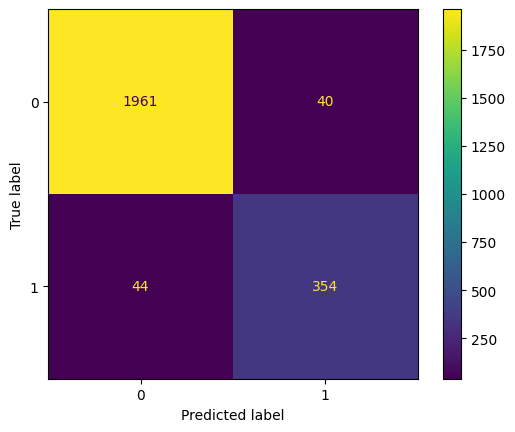

In [105]:
# Generate array of values for confusion matrix
preds = rf2_cv.best_estimator_.predict(X_test)

# Plot a confusion matrix to visualize how well it predicts on the test set.
cm = confusion_matrix(y_test, preds, labels=rf2_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf2_cv.classes_)
disp.plot()

**Insight** 
- The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, where that's actually not the case (who are not actually at risk of doing so). But this is still a strong model.

#### Decision Tree Splits

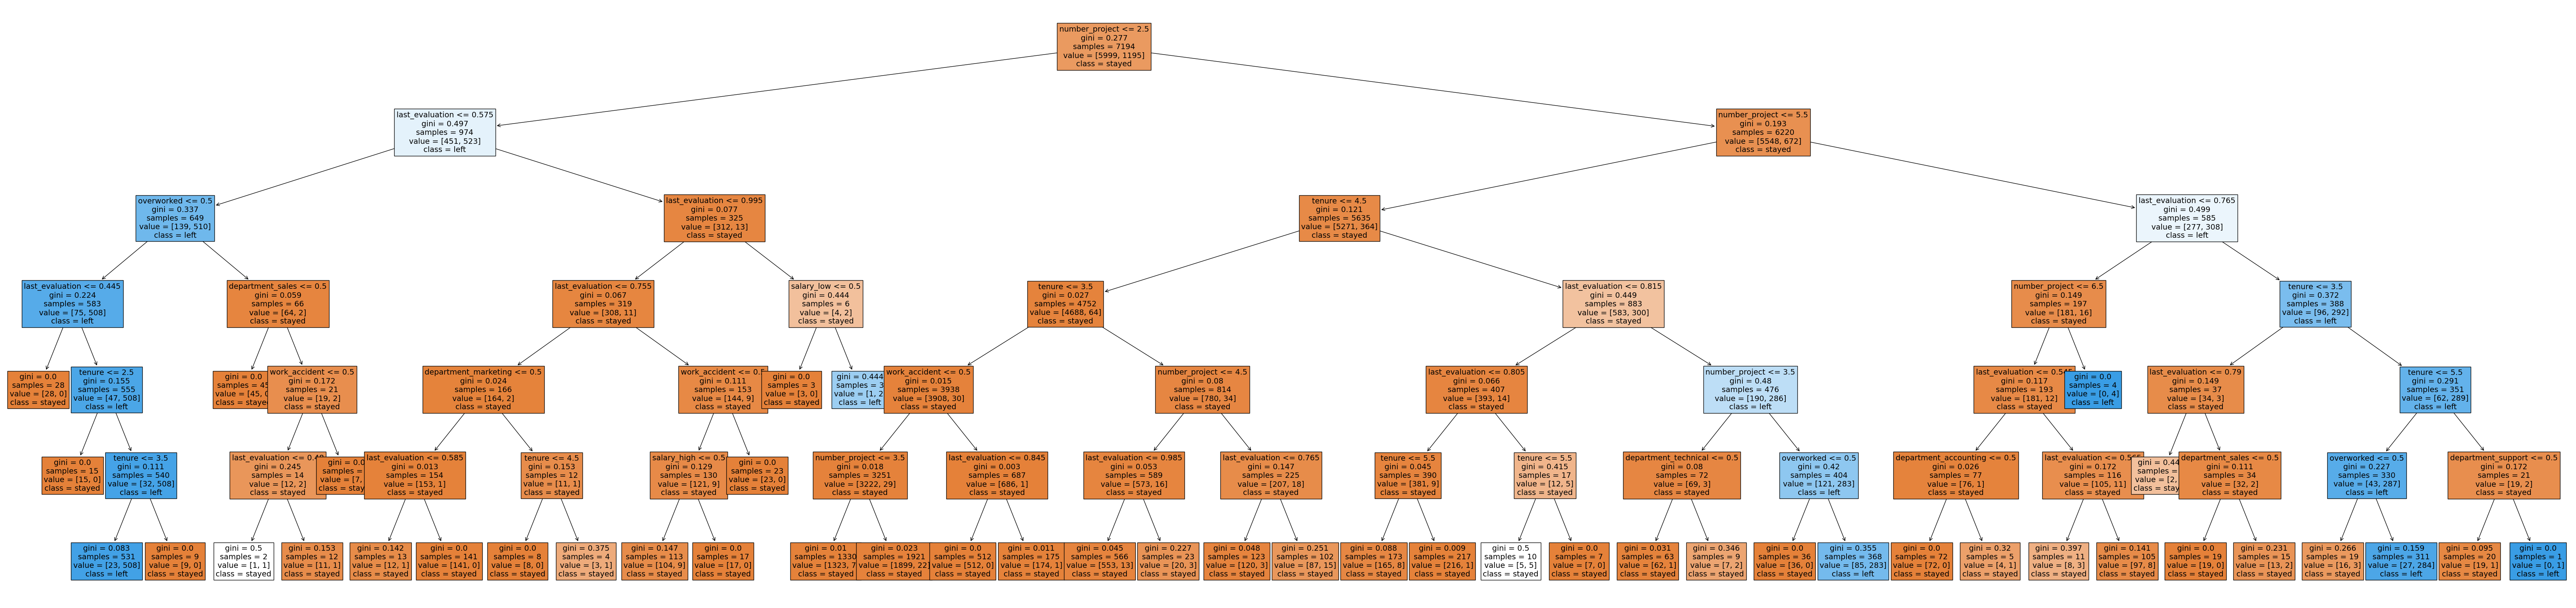

In [106]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(dtree2_cv.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

#### Decision Tree Feature Importance

In [107]:
dtree2_importances = pd.DataFrame(dtree2_cv.best_estimator_.feature_importances_, columns=['gini_importance'], index=X.columns)
dtree2_importances = dtree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = dtree2_importances[dtree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
number_project                0.381767
last_evaluation               0.353482
tenure                        0.169771
overworked                    0.091517
department_support            0.001099
salary_low                    0.000853
department_technical          0.000429
department_sales              0.000357
work_accident                 0.000282
department_accounting         0.000239
salary_high                   0.000120
department_marketing          0.000084

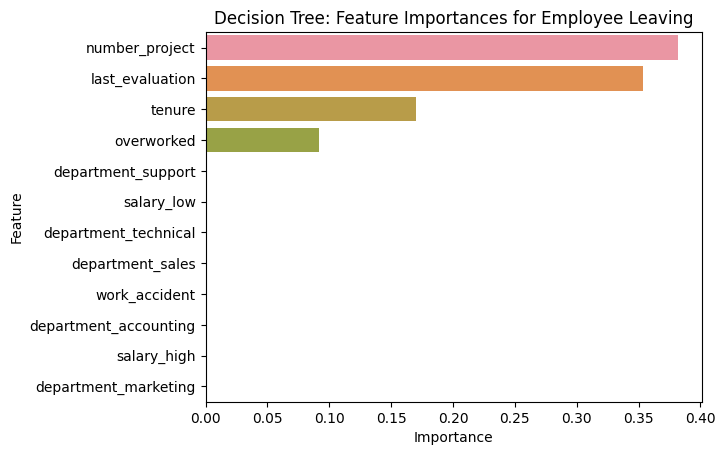

In [108]:
# A barplot to visualize the decision tree feature importances# Create 
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

**Insight** 
- The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

#### Random Forest Feature Importance

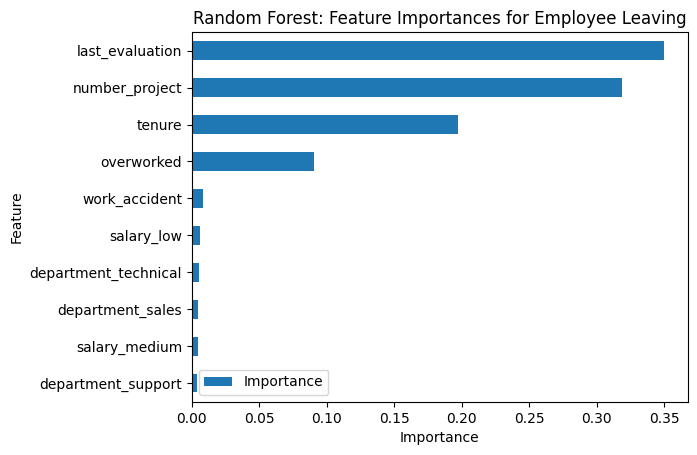

In [109]:
# Get feature importances
feat_impt = rf2_cv.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2_cv.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

**Insight** 
- The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, `overworked`, `work_accident`, and `salary_low` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

### **Executive Summary**

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours, or don't require them to do so. 
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort. 

**Next Steps**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score. 